# Overview

**Analyzing Demand Response Programs Using Randomized Controlled Trials (RCTs)**

This code demonstrates the analysis of energy usage data from a simulated demand response program using Randomized Controlled Trials (RCTs). RCTs are a powerful and well-studied method in the field of experimental design and evaluation, particularly in assessing the impact of interventions like demand response programs.

This repository contains Python code for analyzing energy usage and temperature patterns across different treatment groups in a simulated dataset. The analysis includes generating synthetic data, aggregating energy usage and temperature at hourly intervals, and visualizing the results using matplotlib.

**Necessary Assumptions for Conducting Demand Response Programs Using RCTs**

Before implementing and analyzing a demand response program using RCTs, several critical assumptions must be carefully considered and ideally met to ensure the validity and reliability of the findings:

- Random Assignment:

Assumption: Households are randomly assigned to treatment (intervention) and control (no intervention) groups.  

Rationale: Random assignment minimizes selection bias, ensuring that any observed differences in outcomes between groups can be attributed to the intervention rather than pre-existing differences.

-  Homogeneous Treatment Effect:

Assumption: The impact of the demand response intervention is consistent across different households.  

Rationale: If there are significant variations in how households respond to the intervention (e.g., based on income levels, household size, energy usage patterns), it may confound the results. Methods like subgroup analysis can help explore heterogeneity.

-  Temporal Stability:

Assumption: The demand response program's effectiveness remains stable over time during the study period.

Rationale: Changes in external factors (e.g., economic conditions, weather patterns) or internal factors (e.g., program fatigue, technological advancements) could affect outcomes if not accounted for.

-  Measurement Validity and Reliability:  

Assumption: Accurate and consistent measurement of key variables (e.g., energy usage, temperature) across treatment and control groups.  


Rationale: Measurement errors or inconsistencies can lead to biased estimates of the program's impact. Robust data collection methods and quality assurance protocols are essential.  






**Key Components**  

-  Data Generation and Simulation:  

Parameters such as household count, hours in a day, and treatment group allocation are set.

Energy usage is simulated based on household characteristics and treatment conditions.

Temperature data is generated to simulate varying weather conditions.

-  Data Processing and Aggregation:  

Energy usage and temperature data are aggregated at the hourly level for both control and treatment groups.

Hourly aggregation allows for comparison and visualization of average energy usage and temperature patterns.

-  Visualization:  

Matplotlib is used to create line plots that overlay temperature and energy usage for control and treatment groups.
Secondary axes are utilized to show energy usage alongside temperature, facilitating comparison.

-  Statistical Analysis:  

Statistical metrics such as average treatment effect during peak hours are calculated and displayed.

Checks are implemented to ensure data integrity, including handling of negative energy usage values.

-  Usage  

This code serves as a demonstration of analyzing energy consumption patterns and their relationship with temperature variations. It can be adapted and expanded for similar analyses in energy management, climate impact studies, or related fields.

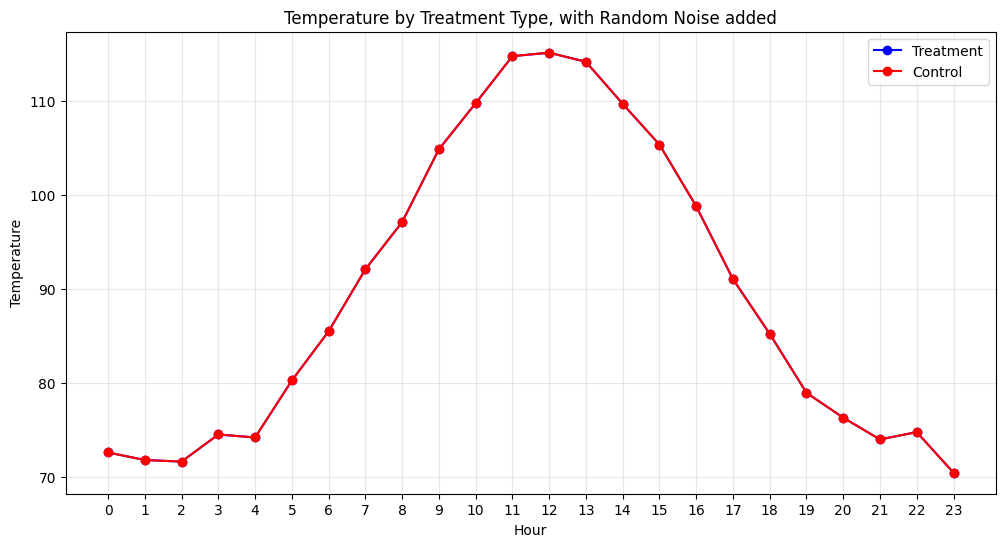

No negative values found in the energy_usage column.


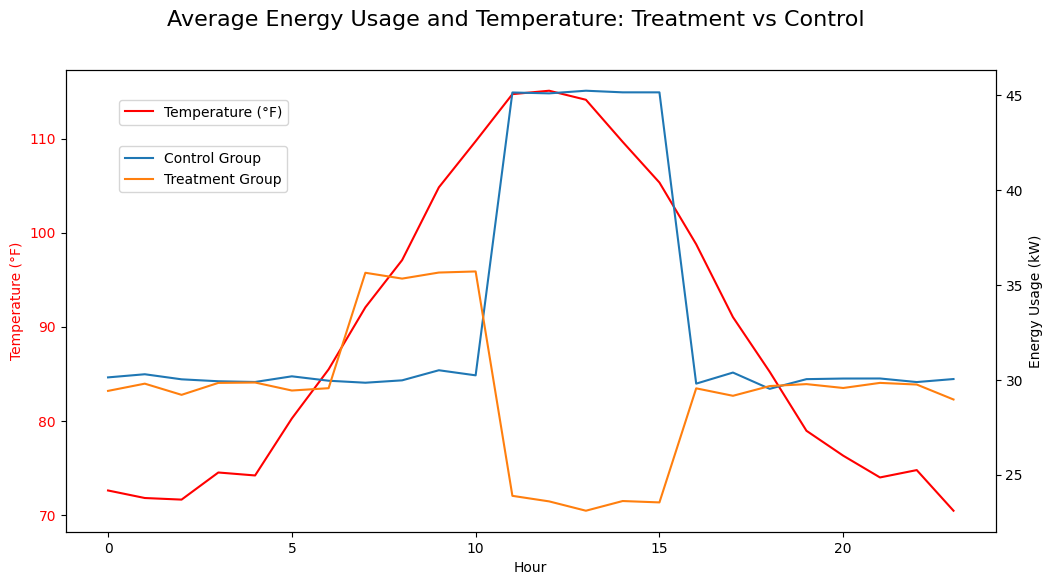

Average Treatment Effect during peak hours: 21.60 kW


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_households = 100
n_hours = 24
treatment_households = 50

# Create base DataFrame with correct household IDs
households = np.repeat(np.arange(n_households), n_hours)
df = pd.DataFrame({
    'household_id': households,
    'hour': np.tile(np.arange(n_hours), n_households),
    'treatment': np.repeat(np.concatenate([np.ones(treatment_households), np.zeros(n_households - treatment_households)]), n_hours)
})

# Function to generate energy usage
def generate_energy_usage(hour, is_treatment, base_load, peak_load, peak_hours, pre_cooling_hours):
    if is_treatment:
        if hour in peak_hours:
            return base_load * 0.8  # Reduced load during peak hours for treatment group
        elif hour in pre_cooling_hours:
            return base_load * 1.2  # Increased load during pre-cooling for treatment group
        else:
            return base_load
    else:
        if hour in peak_hours:
            return peak_load  # Higher load during peak hours for control group
        else:
            return base_load

# Generate energy usage
base_loads = np.random.uniform(25, 35, n_households)  # Random base load kW per household
peak_loads = np.random.uniform(40, 50, n_households)  # Random peak load kW per household
peak_hours = range(11, 16)  # 11 AM to 3 PM
pre_cooling_hours = range(7, 11)  # 7 AM to 10 AM

# Vectorized operation to generate energy usage for each household
df['energy_usage'] = [
    generate_energy_usage(hour, treatment, base_loads[household], peak_loads[household], peak_hours, pre_cooling_hours)
    for hour, treatment, household in zip(df['hour'], df['treatment'], df['household_id'])
]

# Add some random noise to energy usage
df['energy_usage'] += np.random.normal(0, 2, len(df))

# Ensure non-negative energy usage
df['energy_usage'] = df['energy_usage'].clip(lower=0)

# Generate temperature patterns based on climate conditions
temp_base = 70  # Base temperature
temp_peak = 115  # Peak temperature
temp_curve = norm.pdf(np.arange(n_hours), loc=12, scale=4)  # Normal distribution centered at noon
temp_curve = (temp_curve - temp_curve.min()) / (temp_curve.max() - temp_curve.min())
temperatures = temp_base + temp_curve * (temp_peak - temp_base)

# Add some random noise to temperatures
temperatures += np.random.normal(0.9, 0.9, n_hours)

# Assign temperatures to each hour in the dataframe
df['temperature'] = df['hour'].map(dict(enumerate(temperatures)))

# Create masks for treatment == 0 and treatment == 1
mask_treatment_0 = df['treatment'] == 0
mask_treatment_1 = df['treatment'] == 1

# Aggregate energy_usage and temperature at hour level split by treatment 0 and treatment 1
hourly_aggregation = df.groupby('hour').agg(
    control_aggregated_energy=('energy_usage', lambda x: x[mask_treatment_0].mean()),
    treatment_aggregated_energy=('energy_usage', lambda x: x[mask_treatment_1].mean()),
    control_aggregated_weather=('temperature', lambda x: x[mask_treatment_0].mean()),
    treatment_aggregated_weather=('temperature', lambda x: x[mask_treatment_1].mean())
).reset_index()

# Plotting temperature by treatment type, with random noise added
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(hourly_aggregation['hour'], hourly_aggregation['treatment_aggregated_weather'], marker='o', linestyle='-', color='b', label='Treatment')
ax.plot(hourly_aggregation['hour'], hourly_aggregation['control_aggregated_weather'], marker='o', linestyle='-', color='r', label='Control')
ax.set_xlabel('Hour')
ax.set_ylabel('Temperature')
ax.set_title('Temperature by Treatment Type, with Random Noise added')
ax.grid(True, alpha=0.3)
ax.set_xticks(hourly_aggregation['hour'])
ax.legend()
plt.show()

# Sorting dataframe by hour
df = df.sort_values(by='hour')

# Plotting average energy usage and temperatures for treatment and control groups
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['hour'], df['temperature'], label='Temperature (°F)', color='red', linestyle='-')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
for treatment in [0, 1]:
    data = df[df['treatment'] == treatment].groupby('hour')['energy_usage'].mean()
    ax2.plot(data.index, data.values, label=f'{"Control" if treatment == 0 else "Treatment"} Group')

ax2.set_ylabel('Energy Usage (kW)')
ax2.tick_params(axis='y')

fig.suptitle('Average Energy Usage and Temperature: Treatment vs Control', fontsize=16)
ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
ax2.legend(loc='upper left', bbox_to_anchor=(0.05, 0.85))




# Check if there are negative values in energy_usage column
if (df['energy_usage'] < 0).any():
    print("There are negative values in the energy_usage column.")
    # Perform actions to handle negative values if needed
else:
    print("No negative values found in the energy_usage column.")
plt.show();


# Calculate and print the average treatment effect during peak hours
peak_hours_data = df[df['hour'].isin(peak_hours)]
treatment_effect = peak_hours_data.groupby('treatment')['energy_usage'].mean()
print(f"Average Treatment Effect during peak hours: {treatment_effect[0] - treatment_effect[1]:.2f} kW")
plt.show();
